**Задание 1.** Представить текст сообщения в виде последовательности бит 

In [1]:
import os
import sys
import numpy as np

In [2]:
# Задание 1
txt = "Hello world"
bin_txt = list(format(ord(x), '08b') for x in txt) # представление текста как последовательности бит
print(bin_txt)

['01001000', '01100101', '01101100', '01101100', '01101111', '00100000', '01110111', '01101111', '01110010', '01101100', '01100100']


**Задание 2.** Реализовать простейшую операцию стеганографического встраивания текста внутрь изображения в .bmp формате:
* прочитать содержимое будущего контейнера -- файла-изобажения в .bmp формате;
* обойти подряд пиксели контейнера по числу бит в побитовом представлении строки скрываемого сообщения;
* проставить младший бит пикселя контейнера в значение, равное значению соответствующего бита встраиваемого текста (как и лаб 4 в качестве окончания сообщения используйте символ или набор символов, которые заведомо не встретятся в вашем скрываемом тексте);
* Сохранить результат в виде картинки в .bmp формате.


In [3]:
# Задание 2
BMP_HEADER_SIZE = 54 # первые биты заголовка файла и заголовка изображения

# Функция считывания текста и встраивания его в изображение. Step - шаг или кол-во бит, в байте изображения, которые будут заменяться битами текста
def encode_image(input_img_name, output_img_name, txt_file, step):

    if step not in [1, 2, 4, 8]:
        print("Значение шага может быть только 1/2/4/8") # пусть шаг - число младших битов изображения, которые будут кодироваться 
                                                # пусть шаг крантен степеням 2 и не больше 8 бит
        return False

    text_len = os.stat(txt_file).st_size
    img_len = os.stat(input_img_name).st_size

    if text_len >= img_len * step / 8 - BMP_HEADER_SIZE: # проверяем, что текст может быть спрятан в изображение
        print("Слишком много символов")
        return False

    text = open(txt_file, 'r')
    input_image = open(input_img_name, 'rb')
    output_image = open(output_img_name, 'wb')

    bmp_header = input_image.read(BMP_HEADER_SIZE) # считываем первые 54 байта исходного изображения
    output_image.write(bmp_header) # записываем в новое изображение первые 54 байта

    text_mask, img_mask = create_masks(step)

    while True:
        symbol = text.read(1) # считываем по одному символу текста
        if not symbol:
            break
        symbol = ord(symbol)

        for byte_amount in range(0, 8, step): # цикл обхода бит каждого символа текста
            img_byte = int.from_bytes(input_image.read(1), sys.byteorder) & img_mask # считываем побайтово изображение и обнуляем младшие биты этого байта
                                                                                     # используя логическое И
            bits = symbol & text_mask # получаем биты в каждом символе с помощью логической операции И
            bits >>= (8 - step) # сдвигаем биты вправо
            img_byte |= bits # операция логического ИЛИ для замены младших битов в байте изображения

            output_image.write(img_byte.to_bytes(1, sys.byteorder)) # запись полученного байта в изображение
            symbol <<= step

    output_image.write(input_image.read()) # дописываем в изображение оставшиеся биты исходного изображения

    text.close()
    input_image.close()
    output_image.close()

    return True

In [4]:
# Функция создания масок для получения битов текста и замены бит изображения
def create_masks(step):
  
    text_mask = 0b11111111
    img_mask = 0b11111111

    text_mask <<= (8 - step) # маска вида 11000000 при шаге сдвига step = 2 бита
    text_mask %= 256
    img_mask >>= step # маска вида 00111111 при шаге сдвига 2 бита
    img_mask <<= step # маска вида 11111100 при шаге сдвига 2 бита

    return text_mask, img_mask

**Задание 3.** Реализовать обратную операцию чтения встроенного сообщения из картинки-контейнера

In [5]:
# Задание 3
# Функция считывая текста из изображения
def decode_image(encoded_img, output_txt, symbols_to_read, step):

    if step not in [1, 2, 4, 8]:
        print("Значение шага может быть только 1/2/4/8")
        return False

    img_len = os.stat(encoded_img).st_size

    if symbols_to_read >= img_len * step / 8 - BMP_HEADER_SIZE:
        print("Слишком много символов")
        return False

    text = open(output_txt, 'w', encoding='utf-8')
    encoded_bmp = open(encoded_img, 'rb')

    encoded_bmp.seek(BMP_HEADER_SIZE) #пропускаем первые 54 бита

    _, img_mask = create_masks(step)
    img_mask = ~img_mask # опреация логического отрицания чтобы получить нужную маску вида 00000011

    read = 0
    while read < symbols_to_read: # пока не будет прочитано заданное кол-во символов
        symbol = 0

        for bits_read in range(0, 8, step): # цикл считывания бит каждого байта
            img_byte = int.from_bytes(encoded_bmp.read(1), sys.byteorder) & img_mask # получаем младшие биты скрытого текста
            symbol <<= step
            symbol |= img_byte # записываем считанные биты пока не будет заполнен байт символа

        if chr(symbol) == '\n' and len(os.linesep) == 2:
            read += 1

        read += 1
        text.write(chr(symbol))

    text.close()
    encoded_bmp.close()
    return True

In [6]:
def ReadingFile (path): # функция чтения файла
  txt = ''
  f = None
  try:
      f = open(path, 'r') #Открыть файл для чтения
      for ln in f: #Обход строк файла
          txt += ln
  except Exception as e:
      print("Ошибка при работе с файлом:", e)
  finally:
      if f:  # Если файл не открылся, значит 'f' == None и закрывать его не нужно
          f.close()
  return txt

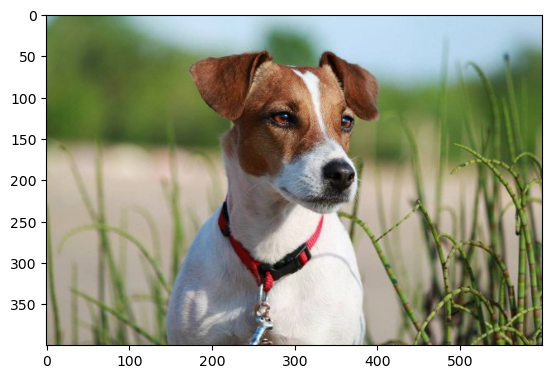

In [8]:
from matplotlib import pyplot as plt

img = plt.imread('dog_img.bmp')
plt.imshow(img)
plt.show()

In [10]:
input_txt = ReadingFile('text.txt')
print("Встраиваемый текст:", input_txt)

Встраиваемый текст: This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is 

In [11]:
encode_image('dog_img.bmp', 'encoded_img.bmp', 'text.txt', 2) # встраиваем текст в изображение используя 2 последних бита каждого цветного канала RGB изображения

True

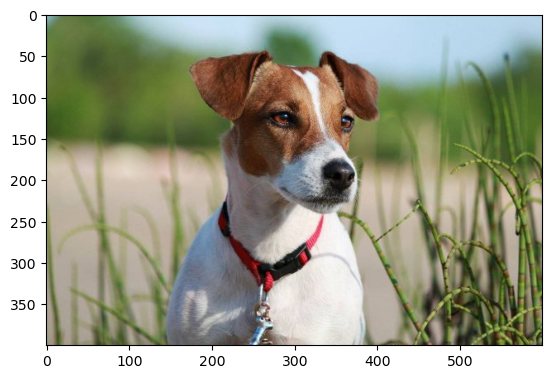

In [13]:
img = plt.imread('encoded_img.bmp') # при изменении 2х бит искажений изображения не видно
plt.imshow(img)
plt.show()

In [19]:
encode_image('dog_img.bmp', 'encoded_img.bmp', 'text.txt', 4) # встраивавем текст используя 4 последних бита изображения

import cv2
img = cv2.imread('encoded_img.bmp') # при изменении 4 бит уже видны помехи внизу изображения
cv2.imshow("Image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

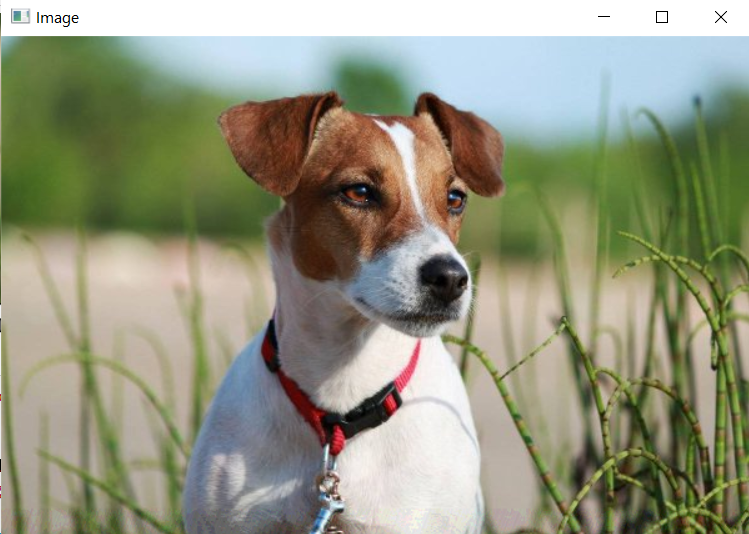

In [20]:
decode_image('encoded_img.bmp', 'decoded.txt', len(input_txt), 4) # считываем весь текст

True

In [21]:
print("Встраиваемый текст:", ReadingFile('decoded.txt'))

Встраиваемый текст: This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is a sample text for encoding! This is 

**Задание 4.** Модифицировать алгоритм встраивания.
Теперь вы обходите не пиксели контейнера а его блоки определенного размера (1x1, 2x2, 3x3 и т.д.) и модифицируете младший бит одного из пикселей блока (пиксель выбирается случайно) так, чтобы:
* если вы пишете единицу, сложение по модулю два (xor) младших бит всех пикселей блока должно давать в результате 1;
* если вы пишете ноль, то сложение по модулю два (xor) младших бит всех пикселей блока должно давать в результате 0.

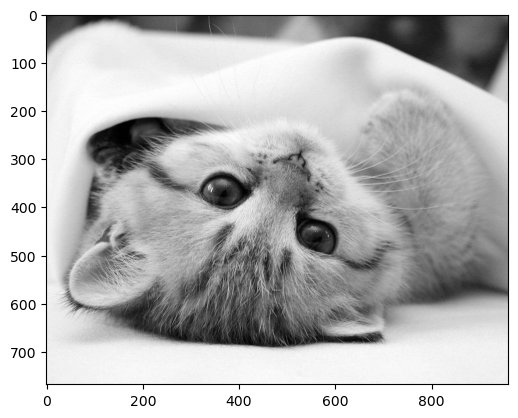

In [25]:
img_grey = cv2.imread('cat_img.bmp', cv2.IMREAD_GRAYSCALE) # считывание изображения в градациях серого
plt.imshow(img_grey, cmap=plt.get_cmap('gray'))
plt.show()

In [26]:
img_grey

array([[ 33,  33,  33, ..., 110, 113, 114],
       [ 33,  33,  34, ..., 108, 110, 112],
       [ 33,  34,  34, ..., 104, 107, 109],
       ...,
       [238, 238, 238, ..., 240, 240, 240],
       [236, 236, 236, ..., 241, 240, 240],
       [235, 235, 235, ..., 239, 238, 237]], dtype=uint8)

In [27]:
img_grey.shape

(768, 960)

In [28]:
img_grey_lst = img_grey.tolist() # преобразование двумерного массива nympy в двумерный список list

In [29]:
def get_chunks(lst, n):
    #Разбивает переданный список lst на маленькие списки размером n
    result = []
    for i in range(0, len(lst), n):
        result.append(lst[i: i + n])
    return result

def get_blocked_matrix(matrix, n):
    #Преобразует матрицу в более сложную структуру. Список, внутри списки, внутри кортежи с матрицами каждого блока нужной размерности n
    result = []
    for line in matrix:
        result.append(get_chunks(line, n))
    result = get_chunks(result, n)

    blocks_list = []
    for chunk in result:
        blocks_list.append(list(zip(*chunk))) #Функция zip() принимает итерируемый объект - список в качестве аргумента. Затем она генерирует список кортежей, которые содержат элементы из списка

    return blocks_list

In [32]:
def block_encode_image(lst_img, txt, block_size): # Функция встраивания текста поблочно
  
  txt += "#" # добавляем символ окончания встраиваемого текста
    
  num_rows_blocks = len(lst_img)/block_size # число блоков в длине изображения
  num_cols_blocks = len(lst_img[0])/block_size # число блоков в ширине изображения
    
  if len(txt) >= num_rows_blocks * 8 * num_cols_blocks:
    print ("Этот текст имеет размер больший, чем вместимость изображения")
    return False

  bin_txt = list(format(ord(x), '08b') for x in txt)
  #print(bin_txt)

  text_mask, img_mask = create_masks(1)
  img_block_lst = get_blocked_matrix(lst_img, block_size) # представляем двумерный список как многомерный, состоящий из блоков
  text_mask_ = text_mask >> 7 # задаем маску чтобы получить последний бит в пикселе
  done = False
  i = 0
  j = 0
  for bin in bin_txt: # обходим текстовое сообщение, представленное в виде битов
    for b in bin:
      b = int(b) # получаем бит в байте каждого символа
      if i < len(img_block_lst):
        lst = img_block_lst[i] # список кортежей 
        if j < len(lst):
          tupl = lst[j] # кортеж в списке кортежей
          val = 0
          val_lst = 0
          for k, min_lst in enumerate(tupl):
            for q, elm in enumerate(min_lst):
              if q == 0:
                val = elm & text_mask_
                continue
              img_byte = elm & text_mask_ # получаем последний бит в пикселе с помощью операции И
              val = val ^ img_byte # выполнение операции XOR для каждого мини-массива
            if k == 0:
              val_lst = val
              continue
            val_lst = val_lst ^ val  # выполнение операции XOR для всего кортежа
          if b == 0:
            if val_lst == 1: # значит нечетные биты
              for k, min_lst in enumerate(tupl):
                for q, elm in enumerate(min_lst):
                  if elm & text_mask_ == 0:
                    lst_img[i*block_size+k][j*block_size+q] |= text_mask_ # операция логического ИЛИ для замены младшего бита в байте изображения на единицу
                    done = True
                    break
                if done:
                  done = False
                  break
          if b == 1:
            if val_lst == 0: # значит биты четные
              n = 0
              for k, min_lst in enumerate(tupl):
                for q, elm in enumerate(min_lst):
                  if elm & text_mask_ == 1:
                    lst_img[i*block_size+k][j*block_size+q] &= img_mask # обнуляем младшие биты байта изображения используя логическое И
                    done = True
                    break
                  else:
                    n += 1 # подсчет нулевых битов в блоке
                if done:
                  done = False
                  break
              if n == block_size*block_size: # если все биты нулевые
                lst_img[i*block_size+k][j*block_size+q] |= text_mask_ # операция логического ИЛИ для замены младшего бита в байте изображения на единицу

          j += 1 # переход к следующему кортежу-блоку
        else:
          i += 1
          j = 0

          if i < len(img_block_lst):
            lst = img_block_lst[i] # список кортежей 
            if j < len(lst):
              tupl = lst[j] # кортеж в списке кортежей
              val = 0
              val_lst = 0
              for k, min_lst in enumerate(tupl):
                for q, elm in enumerate(min_lst):
                  if q == 0:
                    val = elm & text_mask_
                    continue
                  img_byte = elm & text_mask_ # получаем последний бит в пикселе с помощью операции И
                  val = val ^ img_byte # выполнение операции XOR для каждого мини-массива
                if k == 0:
                  val_lst = val
                  continue
                val_lst = val_lst ^ val  # выполнение операции XOR для всего кортежа
              if b == 0:
                if val_lst == 1: # значит нечетные биты
                  for k, min_lst in enumerate(tupl):
                    for q, elm in enumerate(min_lst):
                      if elm & text_mask_ == 0:
                        lst_img[i*block_size+k][j*block_size+q] |= text_mask_ # операция логического ИЛИ для замены младшего бита в байте изображения на единицу
                        done = True
                        break
                    if done:
                      done = False
                      break
              if b == 1:
                if val_lst == 0: # значит биты четные
                  n = 0
                  for k, min_lst in enumerate(tupl):
                    for q, elm in enumerate(min_lst):
                      if elm & text_mask_ == 1:
                        lst_img[i*block_size+k][j*block_size+q] &= img_mask # обнуляем младшие биты байта изображения используя логическое И
                        done = True
                        break
                      else:
                        n += 1 #подсчет нулевых битов в блоке
                    if done:
                      done = False
                      break
                  if n == block_size*block_size: # если все биты нулевые
                    lst_img[i*block_size+k][j*block_size+q] |= text_mask_ # операция логического ИЛИ для замены младшего бита в байте изображения на единицу
              j += 1

  return lst_img

In [39]:
txt = "Hello World! Hello World! Hello World! Hello World!"
print("Встраиваемый текст:", txt)
encoded_img = block_encode_image(img_grey_lst, txt, 4) # получаем двумерный массив изображения со встроенным текстом

Встраиваемый текст: Hello World! Hello World! Hello World! Hello World!


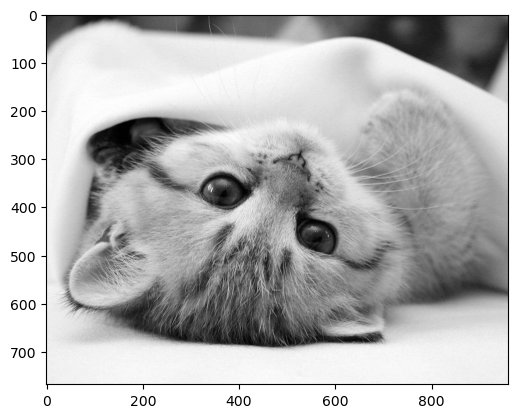

In [36]:
#print(encoded_img)
plt.imshow(encoded_img, cmap='gray')
plt.show()

**Задание 5.** Модифицировать соответствующим образом алгоритм считывания.

In [37]:
def block_decode_image(encoded_img, block_size): # Функция считывания текста

  img_block_lst = get_blocked_matrix(encoded_img, block_size)
  text_mask, _ = create_masks(1)
  text_mask_ = text_mask >> 7 # задаем маску чтобы получить последний бит в пикселе

  output_txt = ""
  symbol = 0
  block_count = 0
  for lst in img_block_lst:
    for tupl in lst:
      bit = 0
      txt_bit = 0
      for k, min_lst in enumerate(tupl):
        for q, elm in enumerate(min_lst):
          if q == 0:
            bit = elm & text_mask_
            continue
          img_bit = elm & text_mask_
          bit = bit ^ img_bit
        if k == 0:
          txt_bit = bit
          continue
        txt_bit = txt_bit ^ bit
      if block_count < 8:
        symbol <<= 1
        symbol |= txt_bit
        block_count += 1
      else:
        ch = chr(symbol)
        if (ch == "#"): # если встретился символ окончания сообщения, то прерываем цикл
          return output_txt
        else:
          output_txt += ch
          symbol = 0
          block_count = 1
          symbol <<= 1
          symbol |= txt_bit

In [40]:
decoded_txt = block_decode_image(encoded_img, 4)
print("Считанный текст:", decoded_txt)

Считанный текст: Hello World! Hello World! Hello World! Hello World!


**Задание 6.** Оценить ограничения встраивания для вашего файла контейнера для разного размера блоков и заполнить таблицу:

| Размер блоков | Число блоков по горизонтали и вертикали | Максимальный размер встраиваемого сообщения | Пропускная способность |
|---------------|:---------------------------------------:|:-------------------------------------------:|:----------------------:|
| 1x1           |                 960*768                 |                    92160                    |          0,125         |
| 2x2           |                 480*384                 |                    23040                    |          0,125         |
| 4x4           |                 240*192                 |                     5760                    |          0,125         |
| 16x16         |                  60*48                  |                     360                     |          0,125         |
| 32x32         |                  30*24                  |                      90                     |          0,125         |
| 64x64         |                  15*12                  |                      22                     |          0,122         |

**Задание 7.** Рассчитать энтропию содержимого изображения
  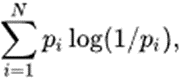
где pi -- вероятность появления данного значения пикселя, N -- число пикселей в изображении, а pi = ki/ N, где ki -- число появлений данного значения пикселя. (Для цветных изображений также брать значение пикселя в одном из цветовых каналов.)
Можно воспользоваться встроенными функциями расчета энтропии в вашей среде.


In [41]:
# Задание 7
from math import log2
from collections import Counter

def entropy (img):
    img_vec = np.ravel(img) # преобразование двумерного массива изображения в вектор
    total = len(img_vec) # число пикселей в изображении
    dic = Counter(img_vec) # словарь с числом появлений каждого символа текста
    return round(sum(val / total * log2(total / val) for val in dic.values()), 5)

In [42]:
print("Энтропия изображения до встраивания:", entropy(img_grey))

Энтропия изображения до встраивания: 7.64467


**Задание 8.** Провести эксперименты по встраиванию разных текстов в ваш контейнер-изображение для разного размера блоков и заполнить вторую таблицу (встраиваемые тексты должны меняться для разного размера блоков и быть близки по размеру к максимально возможному для данного размера блока):

In [47]:
# Задание 8
input_txt = ReadingFile('txt_2.txt')
print("Встраиваемый текст:", input_txt)
print("Длинна текста:", len(input_txt))

Встраиваемый текст: Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a 

In [48]:
size = 2
encoded_img = block_encode_image(img_grey_lst, input_txt, size)
print("Энтропия изображения после встраивания:", entropy(encoded_img))

Энтропия изображения после встраивания: 7.64325


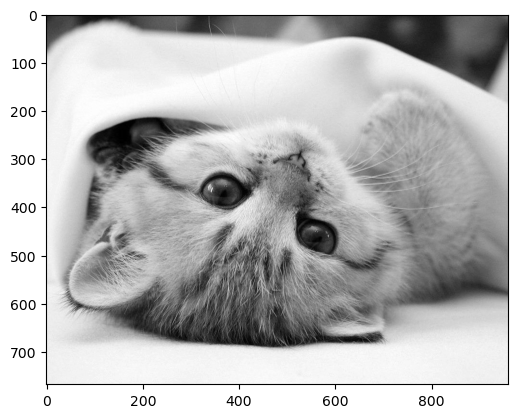

In [51]:
#print(encoded_img)
plt.imshow(encoded_img, cmap='gray')
plt.show()

In [53]:
decoded_txt = block_decode_image(encoded_img, size)
print("Расшифрованный текст:", decoded_txt)
print("Длина расшифрованного текста:", len(decoded_txt))

Расшифрованный текст: Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have a nice day. Hello world. Have a nice day. Hello World! Have 

In [55]:
input_txt = ReadingFile('txt_3.txt')
print("Встраиваемый текст:", input_txt)
print("Длинна текста:", len(input_txt))

Встраиваемый текст: Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dea

In [56]:
size = 4
encoded_img = block_encode_image(img_grey_lst, input_txt, size)
print("Энтропия изображения после встраивания:", entropy(encoded_img))

Энтропия изображения после встраивания: 7.645


In [57]:
decoded_txt = block_decode_image(encoded_img, size)
print("Расшифрованный текст:", decoded_txt)
print("Длина расшифрованного текста:", len(decoded_txt))

Расшифрованный текст: Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my dear friend. Have a nice day, my d

In [60]:
input_txt = ReadingFile('txt_4.txt')
print("Встраиваемый текст:", input_txt)
print("Длинна текста:", len(input_txt))

Встраиваемый текст: We wish you a Merry Christmas; We wish you a Merry Christmas and Happy New Year! We wish you a Merry Christmas; We wish you a Merry Christmas and Happy New Year! We wish you a Merry Christmas; We wish you a Merry Christmas and Happy New Year! We wish you a Merry Christmas; We wish you a Merry Christmas and Happy New Year! We wish you a Merry Christmas;
Длинна текста: 354


In [61]:
size = 16
encoded_img = block_encode_image(img_grey_lst, input_txt, size)
print("Энтропия изображения после встраивания:", entropy(encoded_img))

Энтропия изображения после встраивания: 7.645


In [62]:
decoded_txt = block_decode_image(encoded_img, size)
print("Расшифрованный текст:", decoded_txt)
print("Длина расшифрованного текста:", len(decoded_txt))

Расшифрованный текст: We wish you a Merry Christmas; We wish you a Merry Christmas and Happy New Year! We wish you a Merry Christmas; We wish you a Merry Christmas and Happy New Year! We wish you a Merry Christmas; We wish you a Merry Christmas and Happy New Year! We wish you a Merry Christmas; We wish you a Merry Christmas and Happy New Year! We wish you a Merry Christmas;
Длина расшифрованного текста: 354


In [63]:
input_txt = ReadingFile('txt_5.txt')
print("Встраиваемый текст:", input_txt)
print("Длинна текста:", len(input_txt))

Встраиваемый текст: Hello World! Hello World! Hello World! Hello World! Hello World! Hello World!
Длинна текста: 77


In [64]:
size = 32
encoded_img = block_encode_image(img_grey_lst, input_txt, size)
print("Энтропия изображения после встраивания:", entropy(encoded_img))

Энтропия изображения после встраивания: 7.64501


In [65]:
decoded_txt = block_decode_image(encoded_img, size)
print("Расшифрованный текст:", decoded_txt)
print("Длина расшифрованного текста:", len(decoded_txt))

Расшифрованный текст: Hello World! Hello World! Hello World! Hello World! Hello World! Hello World!
Длина расшифрованного текста: 77


In [66]:
input_txt = ReadingFile('txt_6.txt')
print("Встраиваемый текст:", input_txt)
print("Длинна текста:", len(input_txt))

Встраиваемый текст: Hello World! WORLD.
Длинна текста: 19


In [67]:
size = 64
encoded_img = block_encode_image(img_grey_lst, input_txt, size)
print("Энтропия изображения после встраивания:", entropy(encoded_img))

Энтропия изображения после встраивания: 7.64501


In [68]:
decoded_txt = block_decode_image(encoded_img, size)
print("Расшифрованный текст:", decoded_txt)
print("Длина расшифрованного текста:", len(decoded_txt))

Расшифрованный текст: Hello World! WORLD.
Длина расшифрованного текста: 19


| Размер блоков | Число блоков по горизонтали и вертикали | Размер встраиваемого сообщения | Энтропия контейнера  до встраивания | Энтропия контейнера после встраивания |
|---------------|:---------------------------------------:|:------------------------------:|:-----------------------------------:|---------------------------------------|
|      1x1      |                 960*768                 |              32882             |               7.64467               |                7.62356                |
|      2x2      |                 480*384                 |              19319             |               7.64467               |                7.62415                |
|      4x4      |                 240*192                 |              5115              |               7.64467               |                 7.6326                |
|     16x16     |                  60*48                  |               354              |               7.64467               |                7.63262                |
|     32x32     |                  30*24                  |               77               |               7.64467               |                 7.6326                |
|     64x64     |                  15*12                  |               19               |               7.64467               |                7.63259                |

**Вывод:** При встраивании текста в изображение можно заметить, что энтропия изображения после встраивания почти не отличается от энтропии до встраивания. Это и не удивительно, ведь при встраивании числовые значения пикселей изображения изменились минимально и это никак не отрозилось на энтропии. Таким образом, можно сказать, что по энтропии вряд ли можно судить о наличии встраиваемого сообщения в изображении.

**Контрольные вопросы:**
**Как можно обнаружить факт встраивания скрытого сообщения?**
При методе LSB-стеганографии и при аналогичном, но блочном методе стеганографии факт наличия встраивания скрытого сообщения можно обнаружить визуально, если для сокрытия используется больше 2х последних бита пикселя изображения. В таком случае будут видны помехи в изображении. Если же для сокрытия используется 1 или 2 последних бита изображения, то какие-либо помехи в изображении заметить глазом будет невозможно. Но есть некоторые методы статистического анализа, которыке позволяют выявить встраивание. Например, метод Хи-квадрат, основанный на предположении, что распределение младших битов цветовых
байтов изображения носит случайный характер. Также известен метод визуального выявления наличия LSB-вставки
посредством сопоставления цветовых срезов изображений. Указанный метод выдает относительно неплохие результаты в случае наличия больших полей сплошной заливки на изображении. Также используются нейронные сети, которые в случае большого объема обучающей выборки могут выявить наличие LSB-вставки с ошибкой не менее 15%.

**Какие преобразования над файлом-контейнером могут привести к разрушению скрытого сообщения?**
К разрушению скрытого сообщения могут привести алгоритмы сжатия изображения, также такие геометрические преобразования, как уменьшение размера контейнера путем обрезания, повторот контейнера-изображения даже на незначительный угол, масштабирование, в случае которого используются различные коэффициенты масштабирования по горизонтали и вертикали тоже могут привести к нарушению целостности скрытого сообщения. Также к разрушению может привести наложение дополнительного шума на изображение и преобразование формата.

**Как дополнительно защитить смысл и целостность скрытого сообщения?**
Можно дополнительно использовать шифрование скрываемого сообщения. Также при заполнении контейнера для замены младших битов необходимо случайно выбирать пиксели, в этом случае сложнее будет выявить скрытое сообщение, например, метод Хи-квадрат плохо справляется в таких условиях.

А в целом, необходимо следовать следующим требованиям:

* Свойства контейнера должны быть модифицированы, чтобы изменение невозможно было выявить при визуальном контроле. 

* Стегосообщение должно быть устойчиво к искажениям (сжатиям, преобразованим в другой формат и т.д), в том числе и злонамеренным.

* Для сохранения целостности встраиваемого сообщения необходимо использование кода с исправлением ошибки.

* Для повышения надежности встраиваемое сообщение должно быть продублировано.